<a href="https://colab.research.google.com/github/rajsegar/Spam_Mail_Detection/blob/main/Spam_Mail_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing Email Analysis using LLMs

## Introduction

This Jupyter notebook demonstrates how to use Large Language Models (LLMs) to analyze emails for potential phishing attempts. We'll use the Ollama framework to run a local LLM, then create a simple GUI for one-shot email analysis. Finally, we will test our process with a realworld datasets of phishing emails.

## Setup

Before we begin let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.

In [1]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")

print("Path to dataset files:", path)

100%|██████████| 77.1M/77.1M [00:00<00:00, 100MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/naserabdullahalam/phishing-email-dataset/versions/1


# Step 1: Import Required Libraries
let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import string
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')



import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 2: Load the Dataset
 use a dataset containing labeled emails (Spam or Ham). Let’s load the dataset and inspect its structure.

In [ ]:
df = pd.read_csv('/Phishing_Email.csv')
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


# Setp 3 : Understand the functionality in mail_check model

In [ ]:
df.info()
df['Email Type'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


,count
Email Type,
Safe Email,11322
Phishing Email,7328


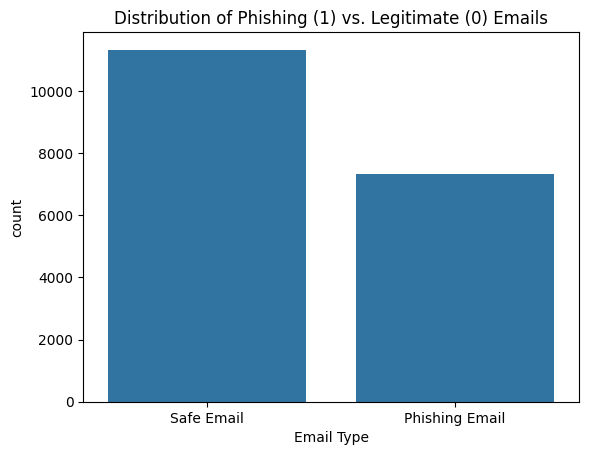

In [ ]:
sns.countplot(x='Email Type', data=df)
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.show()

In [ ]:
df['text'] = df['Email Type'].str.replace('Subject', '')
df.head()

,Unnamed: 0,Email Text,Email Type,text
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,Phishing Email


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
 3   text        18650 non-null  object
dtypes: int64(1), object(3)
memory usage: 582.9+ KB


In [ ]:
df['Email Type'].value_counts()

,count
Email Type,
Safe Email,11322
Phishing Email,7328


In [ ]:
df.describe()

,Unnamed: 0
count,18650.000000
mean,9325.154477
std,5384.327293
min,0.000000
25%,4662.250000
50%,9325.500000
75%,13987.750000
max,18650.000000


# Step 4: Determine Accuracy

Accuracy: 1.0
Confusion Matrix:
[[2315    0]
 [   0 2214]]
Classification Report:
                precision    recall  f1-score   support

Phishing Email       1.00      1.00      1.00      2315
    Safe Email       1.00      1.00      1.00      2214

      accuracy                           1.00      4529
     macro avg       1.00      1.00      1.00      4529
  weighted avg       1.00      1.00      1.00      4529



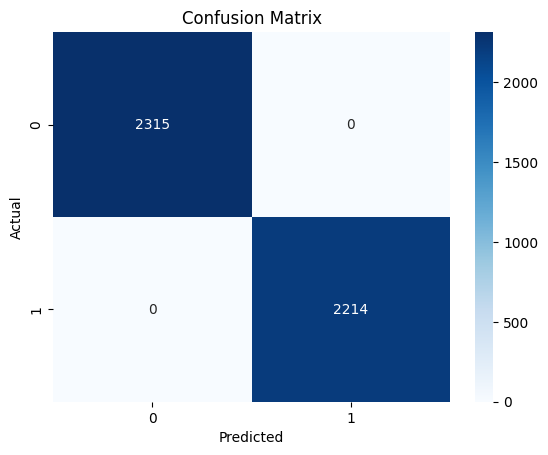

In [ ]:
# Preprocessing the body text

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Replace NaNs with empty strings
df['Email Type'] = df['Email Type'].fillna('')

# Now vectorize safely
X_tfidf = tfidf_vectorizer.fit_transform(df['Email Type'])

# Combining other features with TF-IDF features
features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
features['Email Type'] = df['Email Type']
features['Email Type'] = df['Email Type']

# Ensure there are no missing values in the features
features = features.dropna()

# Splitting the dataset into features and target
X = features.drop('Email Type', axis=1)
y = features['Email Type']

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Building a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Visualizing the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Determine criteria and keyword/features which define the accuracy

In [ ]:
import numpy as np
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Email Type'])
y = df['Email Type']

from sklearn.feature_extraction.text import CountVectorizer

feature_names = vectorizer.get_feature_names_out()
class_probs = model.feature_log_prob_

# Top 20 phishing keywords (class 1)
top_phish_indices = np.argsort(class_probs[1])[1:]
top_phish_keywords = feature_names[top_phish_indices]

print("Top phishing keywords:", top_phish_keywords)



Top phishing keywords: ['email' 'safe']
